## R-peak Detection

We will use a sample [ECG data](https://github.com/pc-ng/Physiological-Demo/blob/master/ECG-HR/sample-ecg-data-70.csv) to demonstrate the R-peak detection, estimating the RR interval, and calculating the heart rate.  
This sample ECG data is generated artificially using [neurokit2](https://neurokit2.readthedocs.io/en/latest/introduction.html). A 5 second data is generated with 100Hz sampling rate.

The data is saved in csv file so we can use pandas to read the data. We can visualize the sample data using matplotlib.


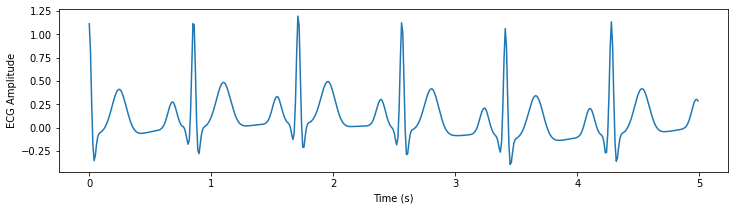

In [22]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 

fs = 100
data = pd.read_csv('sample-ecg-data-70.csv')
plt.figure(figsize=(12,3))
plt.plot(data.index*(1/fs), data.ECG)
plt.xlabel('Time (s)')
plt.ylabel('ECG Amplitude')
plt.show()

From the plot, we can clearly identify the P-wave, T-wave, and the QRS complex.
The goal is to locate all the R-peaks given the 5 second ECG signal.
There are a number of ways to R-peaks detection, one of them is described in [Halmiton algorithm](https://ieeexplore.ieee.org/document/1166717)

Here, we will use a simple moving average approach to R-peak detection. The key steps of this approach is summarized as follows:

- compute the moving average with a window that is at least half the sampling frequency
- mark the region of interest (RoI) for those signals above the moving average
- locate the peak value and peak location for all RoIs
- calculate the average peak value of all peaks, and reject those peaks with peak value less than the average
- compute the duration between each RR-interval, and use the mean duration to compute the heart rate.

### Step 1: Moving average

The sampling rate is 100Hz, so half the sampling rate is 50Hz, which means 50 data points per one second.

In [23]:
# 1. compute the moving average with window of 50 data points
window = 50

# use the convolve function by numpy to compute the moving average
data['ECG_ma'] = np.convolve(data.ECG, np.ones(window), 'same') /window

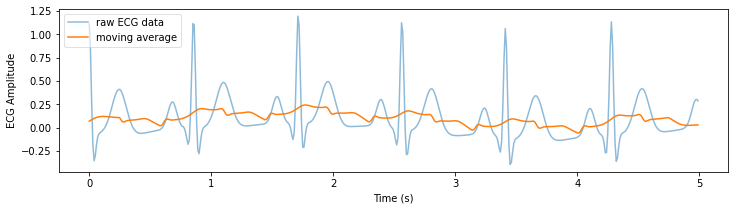

In [24]:
plt.figure(figsize=(12,3))
plt.plot(data.index*(1/fs), data.ECG, alpha=0.5, label = 'raw ECG data')
plt.plot(data.index*(1/fs), data.ECG_ma, label = 'moving average')
plt.xlabel('Time (s)')
plt.ylabel('ECG Amplitude')
plt.legend(framealpha=0.6)
plt.show()

### Step 2: RoIs Identification
From the above plot, we can see that some data points are above the moving average line, and some are below. 
We can mark those above the moving average line as RoI.

In [25]:
# 2. find all the RoIs
data['roi'] = np.zeros(len(data))
track_start = True
for index, row in data.iterrows():
    # check if the point is above the moving average point
    if (row.ECG > row.ECG_ma):
        if (track_start):
            k = int(np.max(data.roi) + 1)
            print(f'[{k}] RoI detected...')
            track_start = False
        data.roi.iloc[index] = k
    else:
        track_start = True


[1] RoI detected...
[2] RoI detected...
[3] RoI detected...
[4] RoI detected...
[5] RoI detected...
[6] RoI detected...
[7] RoI detected...
[8] RoI detected...
[9] RoI detected...
[10] RoI detected...
[11] RoI detected...
[12] RoI detected...
[13] RoI detected...
[14] RoI detected...
[15] RoI detected...
[16] RoI detected...
[17] RoI detected...
[18] RoI detected...
d:\App Developments\__pc_documentation\.pcdocEnv2\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


### Step 3: Peak Detection
For each RoI, we can compute the peak value and peak position by taking the maximum value.

In [26]:
# 3. locate the peak for all RoIs
groups = data.groupby(['roi'])
columns = ['roi', 'value', 'position']
peak = pd.DataFrame(columns = columns)
for k,(roi, group) in enumerate(groups):
    if (roi != 0):
        peak = peak.append(pd.Series({
                                'roi': roi,
                                'value': np.max(group.ECG),
                                'position': group.index[np.argmax(group.ECG)]
                            }, name = k-1))
    

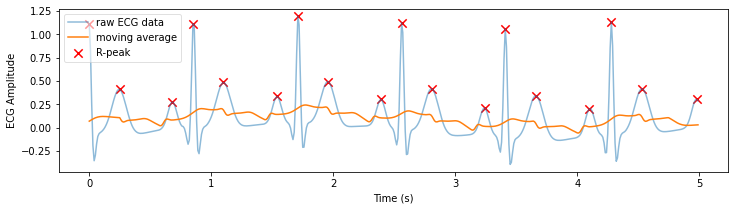

In [27]:
plt.figure(figsize=(12,3))
plt.plot(data.index*(1/fs), data.ECG, alpha=0.5, label = 'raw ECG data')
plt.plot(data.index*(1/fs), data.ECG_ma, label = 'moving average')
plt.scatter(peak.position*(1/fs), peak.value, marker='x', color='red', s=70, label="R-peak")
plt.xlabel('Time (s)')
plt.ylabel('ECG Amplitude')
plt.legend(framealpha=0.6)
plt.show()

### Step 4: Peak Validation
From the above plot, it shows that the peak of QRS complex is detected, as well as the peak from T-wave and P-wave. However, we just want to keep the peak from the QRS complex. We can validate the peak to see if the peak is the one we would like to keep or to reject. The simplest way is to compare each peak value with the average peak value and then keep only those peaks with value greater than the average peak value.

In [28]:
# compute the average peak values
average_peak_value = peak.value.mean()

# keep only the peaks that are greater than the average peak value
val_peak = peak.loc[peak.value>average_peak_value, :]

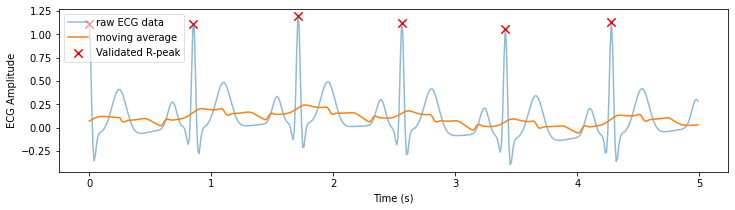

In [29]:
plt.figure(figsize=(12,3))
plt.plot(data.index*(1/fs), data.ECG, alpha=0.5, label = 'raw ECG data')
plt.plot(data.index*(1/fs), data.ECG_ma, label = 'moving average')
plt.scatter(val_peak.position*(1/fs), val_peak.value, marker='x', color='red', s=70, label="Validated R-peak")
plt.xlabel('Time (s)')
plt.ylabel('ECG Amplitude')
plt.legend(framealpha=0.6)
plt.show()

### Step 5: Heart Rate Computation

First, compute the duration between each RR interval, and then use the duration to compute for the heart rate, i.e., 

$$
HR = 60 \frac{1}{d_{RR}}, \qquad (bpm)
$$

In [30]:
RR_duration = (val_peak.position[1:].values - val_peak.position[:-1].values) * 1/fs
HR = 60/np.mean(RR_duration)
print(f'Heart rate: {HR} bpm')

Heart rate: 70.09345794392523 bpm


In [31]:
pd.DataFrame(RR_duration)

,0
0,0.85
1,0.86
2,0.85
3,0.85
4,0.87


## Wrap Up the R-peak Detection

We can group those five steps into a single function that accepts the ECG data and sampling rate as input argument and return a list of tuple containing R-peak values and their corresponding positions. The benefit of using function is that we can reuse the function for different ECG data without rewriting the same code. Let's realize this function implementation for R-peak detection.

In [32]:
def moving_average(ecg, window):
    return np.convolve(ecg, np.ones(window), 'same') /window

def rpeak_detection(ecg, fs):
    data = pd.DataFrame(ecg, columns = ['ECG'])

    # 1. moving average
    data['ECG_ma'] = moving_average(data.ECG, int(fs/2))

    # 2. find all the RoIs
    data['roi'] = np.zeros(len(data))
    track_start = True
    for index, row in data.iterrows():
        # check if the point is above the moving average point
        if (row.ECG > row.ECG_ma):
            if (track_start):
                k = int(np.max(data.roi) + 1)
                track_start = False
            data.roi.iloc[index] = k
        else:
            track_start = True

    # 3. locate the peak for all RoIs
    groups = data.groupby(['roi'])
    columns = ['roi', 'value', 'position']
    peak = pd.DataFrame(columns = columns)
    for k,(roi, group) in enumerate(groups):
        if (roi != 0):
            peak = peak.append(pd.Series({
                                    'roi': roi,
                                    'value': np.max(group.ECG),
                                    'position': group.index[np.argmax(group.ECG)]
                                }, name = k-1))

    # 4. validate the peak
    average_peak_value = peak.value.mean()
    val_peak = peak.loc[peak.value>average_peak_value, :]

    return (val_peak.position, val_peak.value)

Create a function to compute the heart rate given the list of R-peak positions as input argument.

In [33]:
def cal_HR(rpeak_position):
    RR_duration = (rpeak_position[1:].values - rpeak_position[:-1].values) * 1/fs
    return 60/np.mean(RR_duration)

Create a plotting function to visualize the detected R-peaks with respect to the ECG data.

In [34]:
def plot_rpeak(fs, ecg, peak_position, peak_value):
    plt.plot(np.arange(0, len(ecg))*(1/fs), ecg, alpha=0.5, label = 'raw ECG data')
    plt.scatter(peak_position*(1/fs), peak_value, marker='x', color='red', s=70, label="Validated R-peak")
    plt.xlabel('Time (s)')
    plt.ylabel('ECG Amplitude')
    plt.legend(framealpha=0.6)
    plt.show()

We can now call the function by supplying the ECG data and the sampling rate. Besides trying with the ECG data we have previously, we can also try with another two ECG samples: [sample-ecg-data-75](https://github.com/pc-ng/Physiological-Demo/blob/master/ECG-HR/sample-ecg-data-75.csv), [sample-ecg-data-85](https://github.com/pc-ng/Physiological-Demo/blob/master/ECG-HR/sample-ecg-data-85.csv).
Both samples are of 5 second duration with sampling rate equals to 100Hz. Note that the `rpeak_detection` function takes in a numpy array as input argument, so we got to be careful when supplying the ecg input to the function.

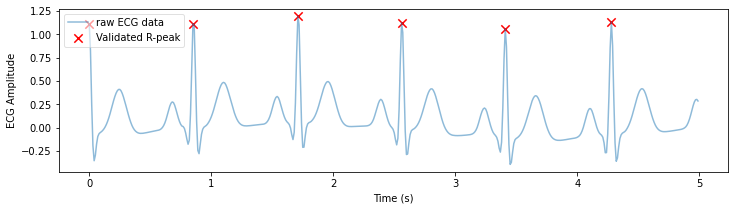

Heart rate: 70.09345794392523 bpm


In [35]:
# try with sample-ecg-data-70
fs = 100
data = pd.read_csv('sample-ecg-data-70.csv')
rpeaks = rpeak_detection(data.ECG, fs)

plt.figure(figsize=(12,3))
plot_rpeak(100, data.ECG, rpeaks[0], rpeaks[1])

# compute the heart rate
HR = cal_HR(rpeaks[0])
print(f'Heart rate: {HR} bpm')

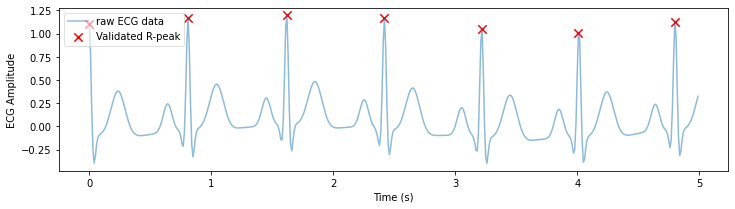

Heart rate: 75.0 bpm


In [36]:
# try with sample-ecg-data-75
fs = 100
data = pd.read_csv('sample-ecg-data-75.csv')

rpeaks = rpeak_detection(data.ECG, fs)

plt.figure(figsize=(12,3))
plot_rpeak(100, data.ECG, rpeaks[0], rpeaks[1])

# compute the heart rate
HR = cal_HR(rpeaks[0])
print(f'Heart rate: {HR} bpm')

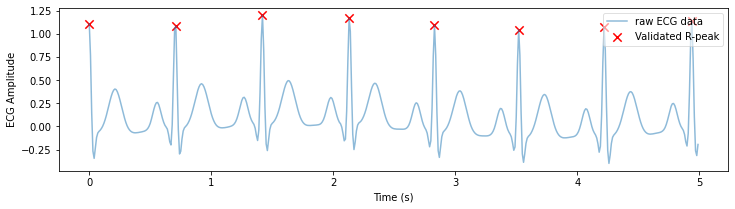

Heart rate: 85.02024291497976 bpm


In [37]:
# try with sample-ecg-data-85
fs = 100
data = pd.read_csv('sample-ecg-data-85.csv')

rpeaks = rpeak_detection(data.ECG, fs)

plt.figure(figsize=(12,3))
plot_rpeak(100, data.ECG, rpeaks[0], rpeaks[1])

# compute the heart rate
HR = cal_HR(rpeaks[0])
print(f'Heart rate: {HR} bpm')

## Resources

The complete code to the above implementation is available [here]().
Many algorithms have been developed to compute the R-peak detection. [Here](https://github.com/berndporr/py-ecg-detectors) you can find a collection of 7 ECG heartbeat detection algorithms implemented in Python. You can try out those peak detection algorithms by installing the package using `pip install py-ecg-detectors`.
